In [3]:
# install older pytorch version
! pip3 install torch==2.2.2



Defaulting to user installation because normal site-packages is not writeable


In [4]:
#Built me pytorch ANN that uses a a scikit wrapper for the pytorch model
#The model should have the following structure: hiddenlayers: 35, neuron per hidden layer: 110, optimizer: 'adamW', learning rate: 0.001, regularization:0.3
#The activation function should be leaky relu for the hidden layers and linear for the output layer. The input layer should have 146 neurons and the output layer should have 1 neuron
#The loss function is mse and the metric is mae, rmse and MAPE
#use NeuralNetRegressor from skorch to build the model
#epochs=150, batch_size=64

#imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#load the data
data = pd.read_csv('one_hot_encoded.csv')



#split the data into features and target
X = data.drop('claim', axis=1)

feature_names = list(X.columns)

y = data['claim']

#split the data into training and testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=69)
# Second split: Split the 40% temporary set into 25% test and 15% evaluation
X_eval, X_test, y_eval, y_test = train_test_split(X_temp, y_temp, test_size=(0.25/0.4), random_state=69)

#put X_train into psnf dataframe
X_train_pandas = pd.DataFrame(X_train, columns=feature_names)

print(X_train.shape, y_train.shape)
#standardize the data
#do deep copy of the data
X_train_non_scaled = X_train.copy()
X_train_non_scaled = X_train_non_scaled.values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train_scaled = X_train.copy()
#make X_train to pandas
X_train_scaled_pandas = pd.DataFrame(X_train_scaled, columns=feature_names)
X_eval = scaler.transform(X_eval)
X_test = scaler.transform(X_test)


#print(X_train.shape, y_train.shape)
#print datatypes
#print(X_train.dtype, y_train.dtype)
#print the type of list
#print(type(X_train), type(y_train))
#print(type(X_train_non_scaled))


(8188, 146) (8188,)


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Define the model class
class PyTorchModel(nn.Module):

        
    def __init__(self, input_dim, hidden_layers, neurons, optimizer, learning_rate, regularization):
        super(PyTorchModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_layers = hidden_layers
        self.neurons = neurons
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.regularization = regularization
        
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, neurons))
        self.layers.append(nn.ReLU())
        
        for _ in range(hidden_layers - 1):
            self.layers.append(nn.Linear(neurons, neurons))
            self.layers.append(nn.ReLU())
        
        self.layers.append(nn.Linear(neurons, 1))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))
# Function to calculate MAE
def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Function to calculate MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) 

#convert y from pandas series to numpy array
y_train = np.asarray(y_train)
y_eval = np.asarray(y_eval)
y_test = np.asarray(y_test)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_eval, dtype=torch.float32), torch.tensor(y_eval, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_dataset_non_scaled = TensorDataset(torch.tensor(X_train_non_scaled, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Create an instance of the PyTorch model
input_dim = X_train.shape[1]
hidden_layers = 35
neurons = 110
optimizer_name = 'adamW'
learning_rate = 0.001
regularization = 0.01

model = PyTorchModel(input_dim, hidden_layers, neurons, optimizer_name, learning_rate, regularization)

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Assuming this is a regression task, change if necessary

if optimizer_name.lower() == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=regularization)
elif optimizer_name.lower() == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=regularization)
else:
    raise ValueError(f"Unsupported optimizer: {optimizer_name}")

# Training loop
num_epochs = 300

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize running_loss to zero at the start of each epoch

# Iterate over batches of data from train_loader
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels.view(-1, 1))  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()  # Accumulate loss

# Print average loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

# Validation loop
model.eval()  # Set the model to evaluation mode
val_loss = 0.0
with torch.no_grad():  # Disable gradient computation
    for inputs, labels in val_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        val_loss += loss.item()

print(f"Validation Loss: {val_loss/len(val_loader)}")

# Evaluate on the training set
model.eval()
train_predictions = []
with torch.no_grad():
    for inputs, _ in train_loader:
        outputs = model(inputs)
        train_predictions.extend(outputs.numpy())
train_predictions = np.array(train_predictions).flatten()
y_train_flat = np.array(y_train).flatten()  # Flatten if necessary
train_rmse = calculate_rmse(y_train_flat, train_predictions)

# Evaluate on the test set
test_predictions = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        test_predictions.extend(outputs.numpy())
test_predictions = np.array(test_predictions).flatten()
y_test_flat = np.array(y_test).flatten()  # Flatten if necessary
test_rmse = calculate_rmse(y_test_flat, test_predictions)
test_mae = calculate_mae(y_test_flat, test_predictions)
test_mape = calculate_mape(y_test_flat, test_predictions)

# Print RMSE, MAE, and MAPE values
print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")
print(f"Test MAPE: {test_mape}%")

#torch.save(model.state_dict(), 'model_pytorch.pth')


Epoch [1/300], Loss: 141506595.96875
Epoch [2/300], Loss: 36867135.75
Epoch [3/300], Loss: 30184338.546875
Epoch [4/300], Loss: 25507714.0703125
Epoch [5/300], Loss: 22718117.1328125
Epoch [6/300], Loss: 20881300.3125
Epoch [7/300], Loss: 17491707.59765625
Epoch [8/300], Loss: 15884220.27734375
Epoch [9/300], Loss: 22699398.39453125
Epoch [10/300], Loss: 25115415.62109375
Epoch [11/300], Loss: 13935639.62890625
Epoch [12/300], Loss: 10280973.681640625
Epoch [13/300], Loss: 8383092.3330078125
Epoch [14/300], Loss: 8126522.373046875
Epoch [15/300], Loss: 7439744.525390625
Epoch [16/300], Loss: 5288071.998046875
Epoch [17/300], Loss: 4727762.8828125
Epoch [18/300], Loss: 4654318.0283203125
Epoch [19/300], Loss: 6102768.837890625
Epoch [20/300], Loss: 5089655.556152344
Epoch [21/300], Loss: 4452924.0361328125
Epoch [22/300], Loss: 4605497.3349609375
Epoch [23/300], Loss: 4617001.5947265625
Epoch [24/300], Loss: 3500021.3974609375
Epoch [25/300], Loss: 3510634.2797851562
Epoch [26/300], Los

In [6]:
# Load the model from the state dictionary file
#model = PyTorchModel(input_dim, hidden_layers, neurons, optimizer_name, learning_rate, regularization)
#model.load_state_dict(torch.load('One_hot_ANN.pth'))

#load my pytorch model which was saved with torch.save(model, 'model.pth')
#model = torch.load('One_hot_ANN.pth')


In [7]:
#get X-tensor of train_dataset
X_tensor = train_dataset.tensors[0]
X_tensor_non_scaled = train_dataset_non_scaled.tensors[0]
y_tensor = train_dataset.tensors[1]

print(X_tensor)
print(y_tensor)


tensor([[-0.8955, -0.3409, -0.1685,  ..., -0.2325, -0.2985, -0.1385],
        [-0.3985,  0.9100, -0.1522,  ..., -0.2325, -0.2985, -0.1385],
        [ 0.8795,  1.1308,  2.8334,  ..., -0.2325, -0.2985, -0.1385],
        ...,
        [-0.6115, -1.5183, -0.7202,  ..., -0.2325, -0.2985, -0.1385],
        [ 0.4535, -0.1202,  0.5617,  ..., -0.2325, -0.2985, -0.1385],
        [ 1.3765, -0.9296, -0.2334,  ..., -0.2325, -0.2985, -0.1385]])
tensor([18246.5000,  6184.2998,  9748.9004,  ...,  4934.7002,  8824.0000,
        12129.5996])


In [8]:
torch.no_grad()


#convert to tensor
example_instance = X.iloc[40]
print(example_instance)
example_instance = scaler.transform([example_instance])
print(example_instance)
example_instance = torch.tensor(example_instance, dtype=torch.float32)
print(example_instance)


print(model(example_instance).item())
print(y.iloc[40])


age                     18.0
weight                  41.0
bmi                     26.7
no_of_dependents         0.0
smoker                   0.0
                        ... 
job_title_Police         0.0
job_title_Politician     0.0
job_title_Singer         1.0
job_title_Student        0.0
job_title_Technician     0.0
Name: 40, Length: 146, dtype: float64
[[-1.53444884 -1.73906248 -0.57412949 -0.91432184 -0.49223989  0.79259407
   0.52174589  1.87185747  0.97825302 -0.97825302 -0.0948456  -0.07679066
  -0.0799459  -0.10423146 -0.06737448 -0.09679275 -0.08223486 -0.06737448
   0.26174611 -0.08519369 -0.14027193 -0.08663628 -0.11119351 -0.0664537
  -0.09218776 -0.10482848 -0.13799164 -0.08875749 -0.10119581 -0.09807016
  -0.08071591 -0.11615407 -0.14778197 -0.13799164 -0.09151166 -0.08805593
  -0.08945373 -0.09218776 -0.0954989  -0.11882506 -0.08298418 -0.07916859
  -0.08875749 -0.09743347 -0.09614792 -0.11342362 -0.12298462 -0.08591792
  -0.13093073 -0.0948456  -0.13189248 -0.07916859 -0

C:\Users\kobra\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [9]:
import shap
shap.initjs()
#use deep explainer

torch.no_grad()

In [10]:
e = shap.DeepExplainer(model, X_tensor)
print(e)




In [11]:
shap_values = e.shap_values(example_instance, check_additivity=False)
print(shap_values)

print(shap_values.sum())


[[[-4.73063525e+03]
  [-3.97760315e+02]
  [-5.61034668e+02]
  [-6.26611755e+02]
  [-2.54164648e+03]
  [ 3.66654243e+01]
  [-1.14341217e+02]
  [-4.39348206e+02]
  [ 1.33526123e+02]
  [ 1.67705383e+02]
  [-7.61547089e+01]
  [-2.53929157e+01]
  [-3.93282242e+01]
  [-4.21543770e+01]
  [-3.15244160e+01]
  [-4.04663963e+01]
  [-7.65826263e+01]
  [-3.54762077e+01]
  [-2.02278564e+02]
  [-4.48104362e+01]
  [-1.01899016e+00]
  [-5.69788599e+00]
  [-2.64344215e+00]
  [-1.82097697e+00]
  [ 1.25117987e-01]
  [ 6.30522776e+00]
  [-6.56571150e+00]
  [ 6.03144836e+00]
  [-3.45522195e-01]
  [-4.61469316e+00]
  [-3.34147286e+00]
  [ 2.10556626e+00]
  [-3.28144073e+00]
  [-1.25777273e+01]
  [-3.82889628e+00]
  [ 4.05337906e+00]
  [-1.08412945e+00]
  [-6.61562395e+00]
  [ 3.00014400e+00]
  [-7.64832675e-01]
  [-7.81100154e-01]
  [-4.79825640e+00]
  [ 3.44474196e+00]
  [-9.19671297e-01]
  [ 5.20329237e-01]
  [-5.97878170e+00]
  [ 2.71581054e+00]
  [-3.66414115e-02]
  [-1.79403210e+01]
  [ 1.33262724e-01]


In [12]:
explanation = shap.Explanation(values=shap_values, base_values=e.expected_value[0], data=X.iloc[40], feature_names=feature_names)
print(explanation)
print(explanation.values.shape)

.values =
array([[[-4.73063525e+03],
        [-3.97760315e+02],
        [-5.61034668e+02],
        [-6.26611755e+02],
        [-2.54164648e+03],
        [ 3.66654243e+01],
        [-1.14341217e+02],
        [-4.39348206e+02],
        [ 1.33526123e+02],
        [ 1.67705383e+02],
        [-7.61547089e+01],
        [-2.53929157e+01],
        [-3.93282242e+01],
        [-4.21543770e+01],
        [-3.15244160e+01],
        [-4.04663963e+01],
        [-7.65826263e+01],
        [-3.54762077e+01],
        [-2.02278564e+02],
        [-4.48104362e+01],
        [-1.01899016e+00],
        [-5.69788599e+00],
        [-2.64344215e+00],
        [-1.82097697e+00],
        [ 1.25117987e-01],
        [ 6.30522776e+00],
        [-6.56571150e+00],
        [ 6.03144836e+00],
        [-3.45522195e-01],
        [-4.61469316e+00],
        [-3.34147286e+00],
        [ 2.10556626e+00],
        [-3.28144073e+00],
        [-1.25777273e+01],
        [-3.82889628e+00],
        [ 4.05337906e+00],
        [-1.084129

In [13]:
#Respace the explanation.values from 1, 146, 1 to 1,146
print(explanation.values)
explanation.values = explanation.values.reshape(146)
print(explanation.values.shape)
print(explanation.values)


[[[-4.73063525e+03]
  [-3.97760315e+02]
  [-5.61034668e+02]
  [-6.26611755e+02]
  [-2.54164648e+03]
  [ 3.66654243e+01]
  [-1.14341217e+02]
  [-4.39348206e+02]
  [ 1.33526123e+02]
  [ 1.67705383e+02]
  [-7.61547089e+01]
  [-2.53929157e+01]
  [-3.93282242e+01]
  [-4.21543770e+01]
  [-3.15244160e+01]
  [-4.04663963e+01]
  [-7.65826263e+01]
  [-3.54762077e+01]
  [-2.02278564e+02]
  [-4.48104362e+01]
  [-1.01899016e+00]
  [-5.69788599e+00]
  [-2.64344215e+00]
  [-1.82097697e+00]
  [ 1.25117987e-01]
  [ 6.30522776e+00]
  [-6.56571150e+00]
  [ 6.03144836e+00]
  [-3.45522195e-01]
  [-4.61469316e+00]
  [-3.34147286e+00]
  [ 2.10556626e+00]
  [-3.28144073e+00]
  [-1.25777273e+01]
  [-3.82889628e+00]
  [ 4.05337906e+00]
  [-1.08412945e+00]
  [-6.61562395e+00]
  [ 3.00014400e+00]
  [-7.64832675e-01]
  [-7.81100154e-01]
  [-4.79825640e+00]
  [ 3.44474196e+00]
  [-9.19671297e-01]
  [ 5.20329237e-01]
  [-5.97878170e+00]
  [ 2.71581054e+00]
  [-3.66414115e-02]
  [-1.79403210e+01]
  [ 1.33262724e-01]


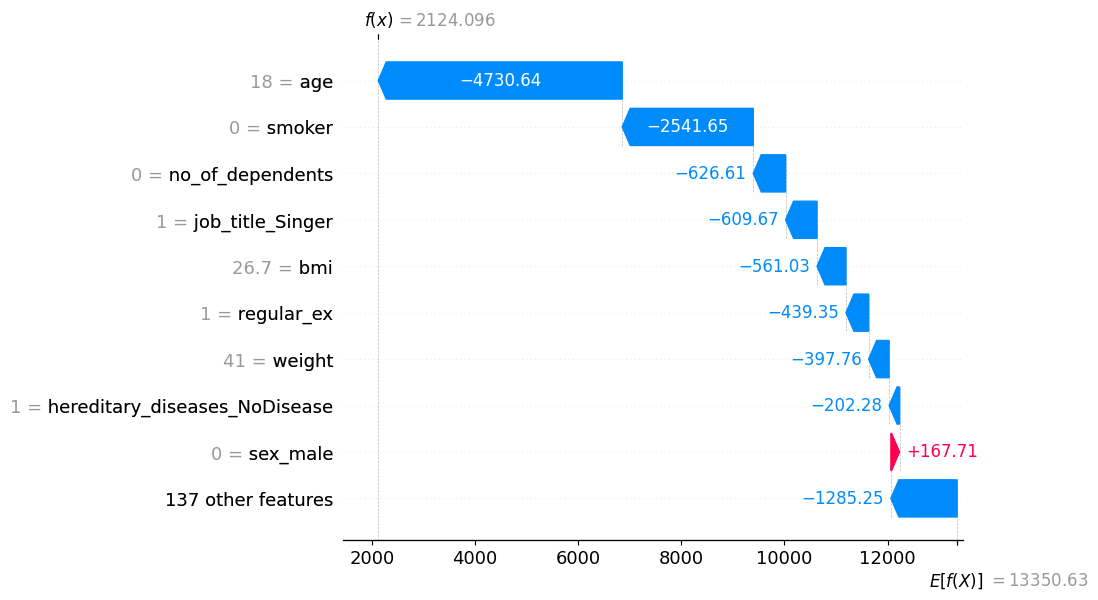

In [14]:
#display all feature contribution in a waterfall plot
#print(X.iloc[0])
#print(explanation)
shap.waterfall_plot(explanation)
#print the prediction that shap stored


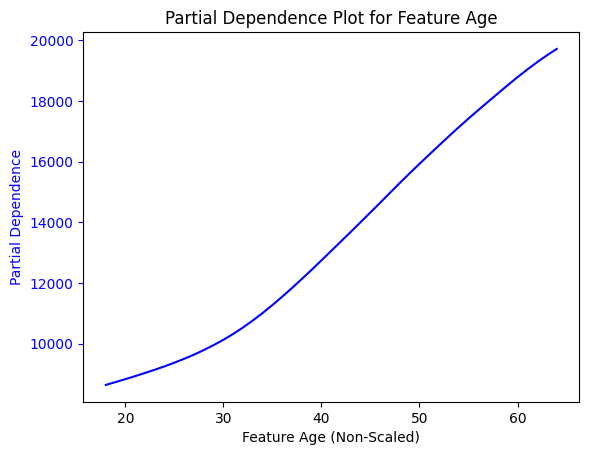

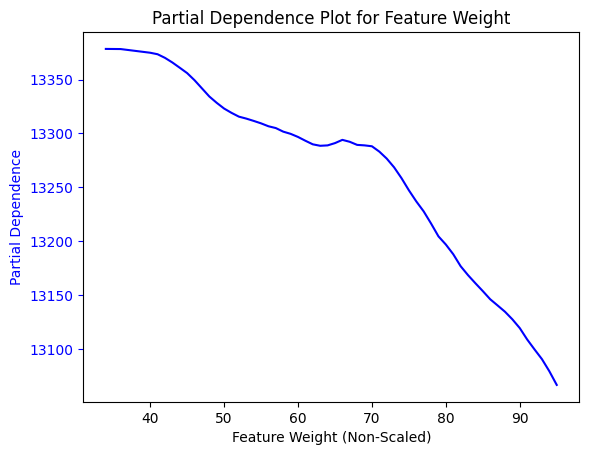

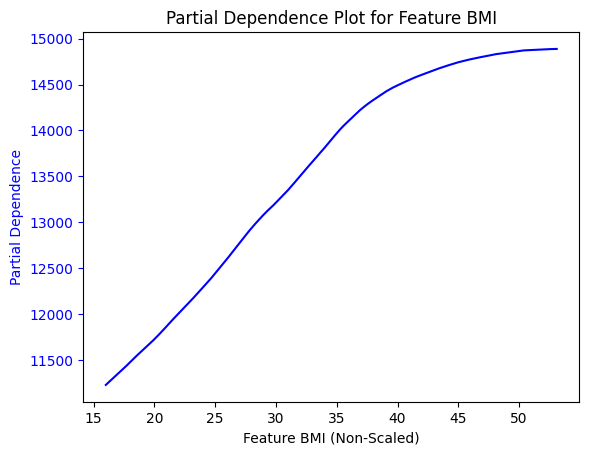

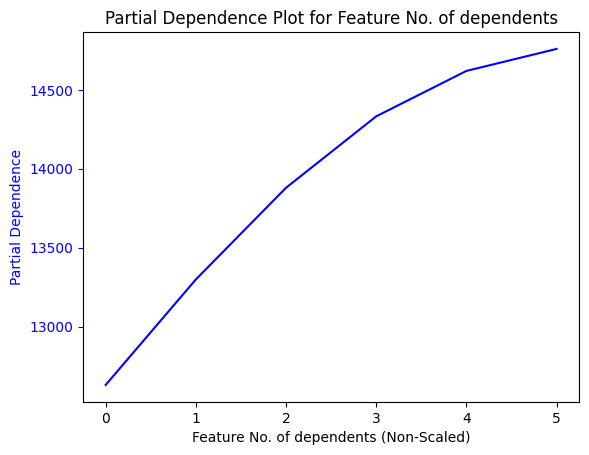

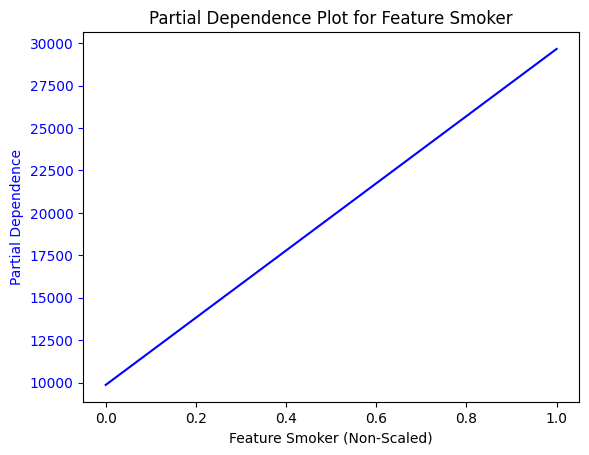

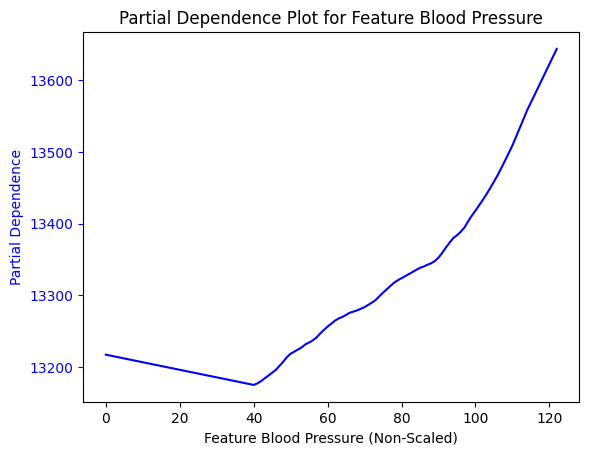

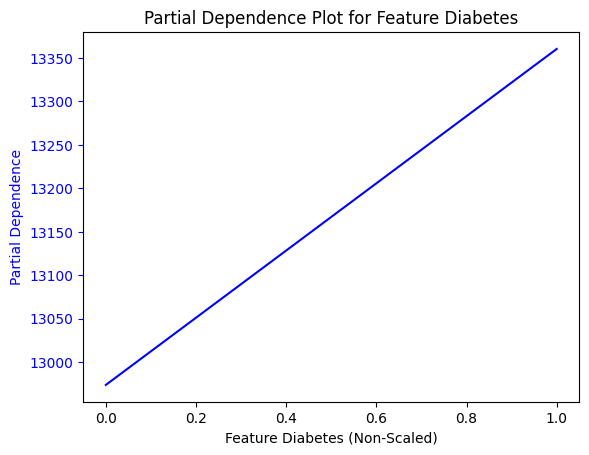

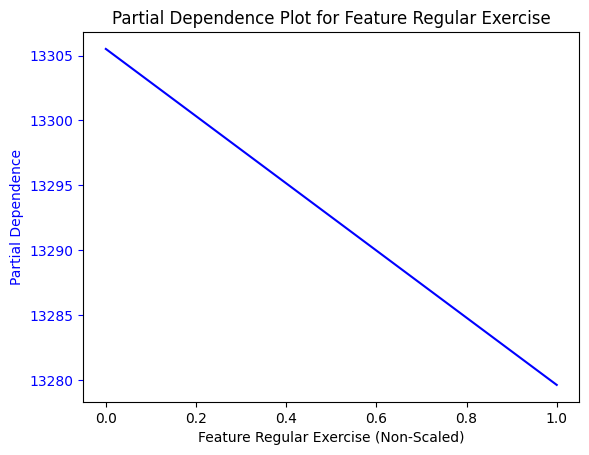

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch

feature_names = ['Age', 'Weight', 'BMI', 'No. of dependents', 'Smoker', 'Blood Pressure', 'Diabetes', 'Regular Exercise']

def plot_partial_dependence(model, X_scaled, X_non_scaled, feature_index):
    pd_values = []

    # Iterate through X_scaled and get the unique values of the feature
    feature_values_scaled = np.unique(X_scaled[:, feature_index])
    feature_values_non_scaled = np.unique(X_non_scaled[:, feature_index])

    for value in feature_values_scaled:
        X_temp = X_scaled.clone()
        X_temp[:, feature_index] = torch.tensor(value, dtype=torch.float32)  # Convert numpy value to torch tensor
        with torch.no_grad():
            preds = model(X_temp).numpy()
        pd_values.append(preds.mean())

    fig, ax1 = plt.subplots()

    ax1.plot(feature_values_non_scaled, pd_values, 'b-')
    ax1.set_xlabel(f'Feature {feature_names[feature_index]} (Non-Scaled)')
    ax1.set_ylabel('Partial Dependence', color='b')
    ax1.tick_params('y', colors='b')

    plt.title(f'Partial Dependence Plot for Feature {feature_names[feature_index]}')
    plt.show()

# Plot PDP for each feature using training data
for i in range(len(feature_names)):
    plot_partial_dependence(model, X_tensor, X_tensor_non_scaled, i)


In [16]:
print(X_train_pandas)

        age  weight   bmi  no_of_dependents  smoker  bloodpressure  diabetes  \
2787   27.0      60  29.2                 0       1             44         1   
6447   34.0      77  29.3                 3       0             88         1   
11710  52.0      80  47.7                 1       0             60         0   
11800  59.0      67  25.5                 0       0             90         1   
5185   58.0      55  24.3                 0       0             74         1   
...     ...     ...   ...               ...     ...            ...       ...   
8631   27.0      78  36.1                 0       1             70         0   
9818   40.0      62  25.0                 2       0              0         1   
10859  31.0      44  25.8                 2       0             74         1   
4041   46.0      63  33.7                 1       0             82         1   
7371   59.0      52  28.8                 0       0             64         1   

       regular_ex  sex_female  sex_male

In [17]:
print(X_train_scaled_pandas)

           age    weight       bmi  no_of_dependents   smoker  bloodpressure  \
0    -0.895461 -0.340925 -0.168468         -0.914322  2.03153      -1.240539   
1    -0.398470  0.910040 -0.152241          1.563547 -0.49224       0.995907   
2     0.879506  1.130799  2.833430         -0.088366 -0.49224      -0.427286   
3     1.376497  0.174179 -0.768847         -0.914322 -0.49224       1.097564   
4     1.305498 -0.708856 -0.963565         -0.914322 -0.49224       0.284311   
...        ...       ...       ...               ...      ...            ...   
8183 -0.895461  0.983627  0.951159         -0.914322  2.03153       0.080998   
8184  0.027522 -0.193752 -0.849980          0.737591 -0.49224      -3.476985   
8185 -0.611466 -1.518304 -0.720168          0.737591 -0.49224       0.284311   
8186  0.453514 -0.120166  0.561724         -0.088366 -0.49224       0.690937   
8187  1.376497 -0.929614 -0.233373         -0.914322 -0.49224      -0.223972   

      diabetes  regular_ex  sex_female 

In [18]:
#convert X_train_pandas to tensor
X_train_tensor = torch.tensor(X_train_pandas.values, dtype=torch.float32)
print(X_train_tensor)

tensor([[27.0000, 60.0000, 29.2000,  ...,  0.0000,  0.0000,  0.0000],
        [34.0000, 77.0000, 29.3000,  ...,  0.0000,  0.0000,  0.0000],
        [52.0000, 80.0000, 47.7000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [31.0000, 44.0000, 25.8000,  ...,  0.0000,  0.0000,  0.0000],
        [46.0000, 63.0000, 33.7000,  ...,  0.0000,  0.0000,  0.0000],
        [59.0000, 52.0000, 28.8000,  ...,  0.0000,  0.0000,  0.0000]])


In [19]:
#convert X_train_scaled_pandas to tensor
X_train_scaled_tensor = torch.tensor(X_train_scaled_pandas.values, dtype=torch.float32)
print(X_train_scaled_tensor)

tensor([[-0.8955, -0.3409, -0.1685,  ..., -0.2325, -0.2985, -0.1385],
        [-0.3985,  0.9100, -0.1522,  ..., -0.2325, -0.2985, -0.1385],
        [ 0.8795,  1.1308,  2.8334,  ..., -0.2325, -0.2985, -0.1385],
        ...,
        [-0.6115, -1.5183, -0.7202,  ..., -0.2325, -0.2985, -0.1385],
        [ 0.4535, -0.1202,  0.5617,  ..., -0.2325, -0.2985, -0.1385],
        [ 1.3765, -0.9296, -0.2334,  ..., -0.2325, -0.2985, -0.1385]])


In [20]:
#write a method that extracts the unique values of a feature from the training data, given the feature name, i.e. 'age
def get_unique_values(X_train_pandas, feature_name):
    #return the unique values of the feature of pandas dataframe
    unique_value_list = X_train_pandas[feature_name].unique()
    #sort the unique values
    unique_value_list.sort()
    return unique_value_list

#test the method
print(get_unique_values(X_train_pandas, 'age'))





[18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64.]


In [21]:
#Given the unique values of a feature, write a method that for given data it gives every row with the feature value replaced with the unique value and does this for all unique values
def replace_feature_value(X_train_pandas, feature_name, unique_value):
    X_bootstrapp = X_train_pandas.copy()
    X_bootstrapp[feature_name] = unique_value
    return X_bootstrapp

#test the method
print(replace_feature_value(X_train_pandas, 'age', 20))





       age  weight   bmi  no_of_dependents  smoker  bloodpressure  diabetes  \
2787    20      60  29.2                 0       1             44         1   
6447    20      77  29.3                 3       0             88         1   
11710   20      80  47.7                 1       0             60         0   
11800   20      67  25.5                 0       0             90         1   
5185    20      55  24.3                 0       0             74         1   
...    ...     ...   ...               ...     ...            ...       ...   
8631    20      78  36.1                 0       1             70         0   
9818    20      62  25.0                 2       0              0         1   
10859   20      44  25.8                 2       0             74         1   
4041    20      63  33.7                 1       0             82         1   
7371    20      52  28.8                 0       0             64         1   

       regular_ex  sex_female  sex_male  ...  job_t

In [22]:
def get_predictions(model, feature_name, X_train_pandas, X_train_pandas_scaled):
    unique_values_normal = get_unique_values(X_train_pandas, feature_name)
    unique_values_scaled = get_unique_values(X_train_scaled_pandas, feature_name)

    average_y_values = []
    for value in unique_values_scaled:
        X_temp = replace_feature_value(X_train_scaled_pandas, feature_name, value)
        #print(X_temp)
        X_temp = torch.tensor(X_temp.values, dtype=torch.float32)
        with torch.no_grad():
            preds = model(X_temp).numpy()
            #print(preds)
        average_y_values.append(preds.mean())

    return unique_values_normal, average_y_values

#test the method
print(get_predictions(model, 'age', X_train_pandas, X_train_scaled_pandas))


(array([18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30.,
       31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43.,
       44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56.,
       57., 58., 59., 60., 61., 62., 63., 64.]), [8638.483, 8733.161, 8829.548, 8928.857, 9032.947, 9140.16, 9252.275, 9372.273, 9500.244, 9638.206, 9788.735, 9952.17, 10128.025, 10321.329, 10533.032, 10764.51, 11010.548, 11274.622, 11548.846, 11836.471, 12133.509, 12436.139, 12746.905, 13060.342, 13374.34, 13690.273, 14009.312, 14330.004, 14651.766, 14976.629, 15301.856, 15619.197, 15929.446, 16235.064, 16539.926, 16840.385, 17136.11, 17423.0, 17702.512, 17977.996, 18250.924, 18523.588, 18788.01, 19040.344, 19281.426, 19507.814, 19718.94])


In [23]:
#plot the predictions
def plot_predictions(model, feature_name, X_train_pandas, X_train_pandas_scaled):
    #print('here3')
    unique_values, y_values = get_predictions(model, feature_name, X_train_pandas, X_train_scaled_pandas)
    #print('here4')
    plt.plot(unique_values, y_values)
    plt.xlabel(feature_name)
    plt.ylabel('Predictions')
    plt.title(f'Predictions for feature {feature_name}')
    plt.show()





In [26]:
#get mape for the model for the test data and the training data 

def get_mape(model, X_tensor, y_tensor):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in train_loader:
            outputs = model(inputs)
            predictions.extend(outputs.numpy())
    predictions = np.array(predictions).flatten()
    y_flat = np.array(y_tensor).flatten()  # Flatten if necessary
    mape = calculate_mape(y_flat, predictions)
    return mape

#test the method for training data
print(get_mape(model, X_tensor, y_tensor))

#test the method for test data
X_test_tensor = test_dataset.tensors[0]
y_test_tensor = test_dataset.tensors[1]
print(get_mape(model, X_test_tensor, y_test_tensor))


1.7369328


ValueError: operands could not be broadcast together with shapes (3413,) (8188,) 

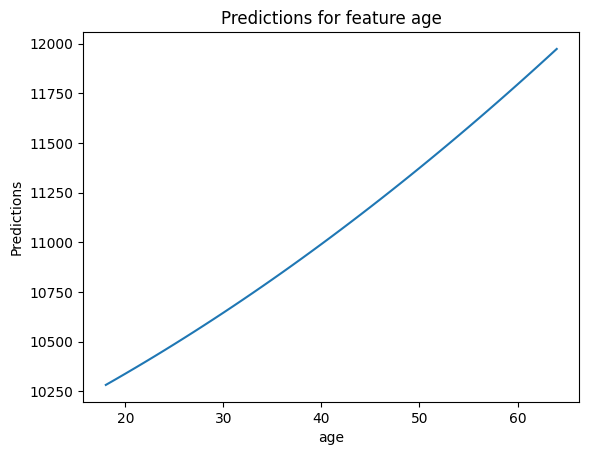

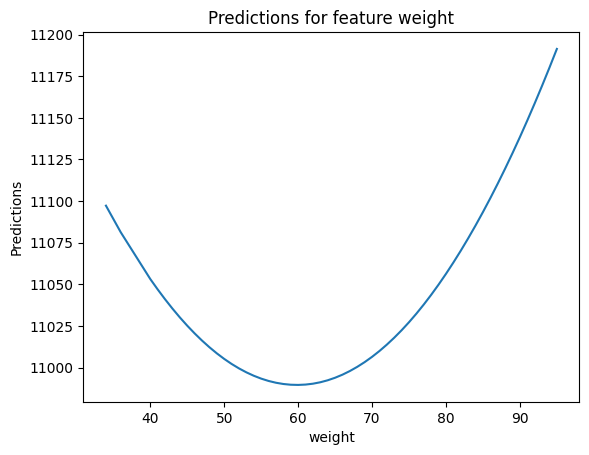

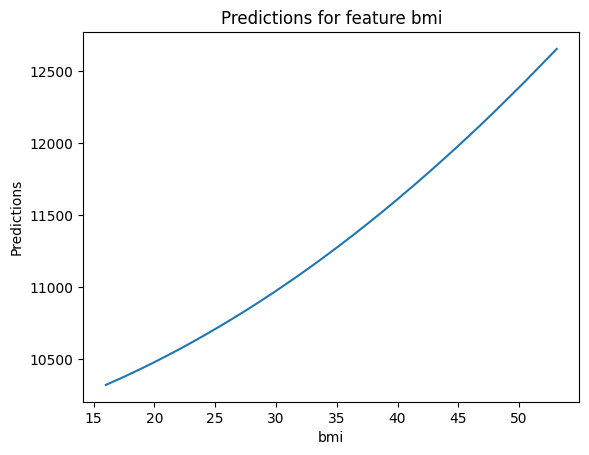

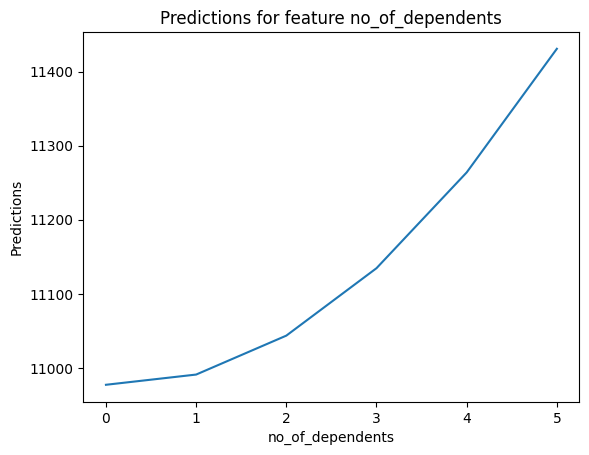

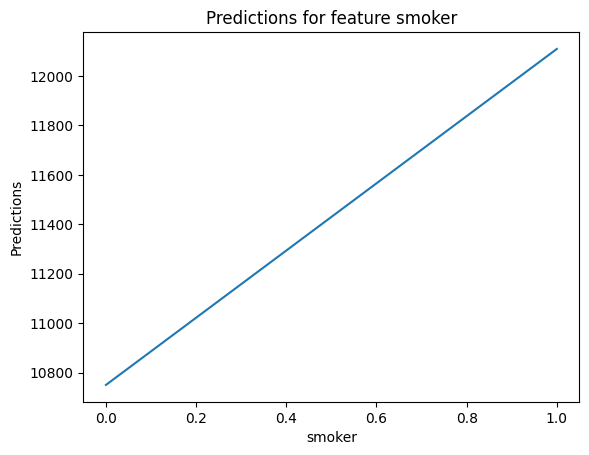

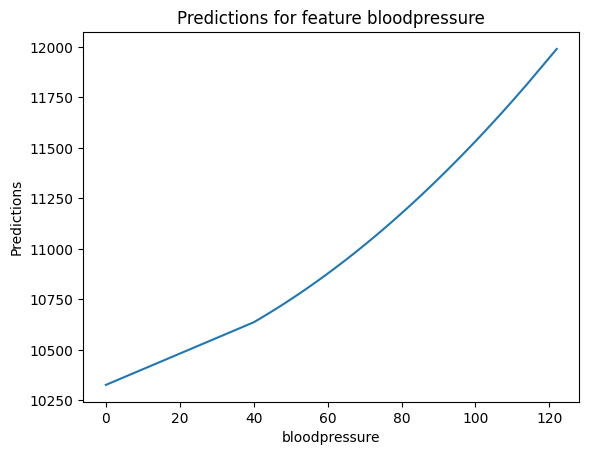

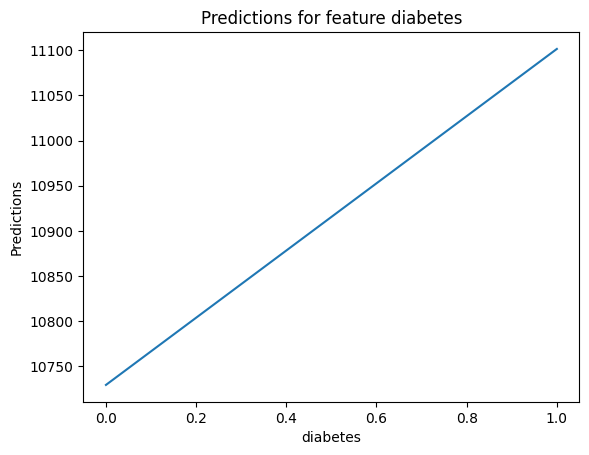

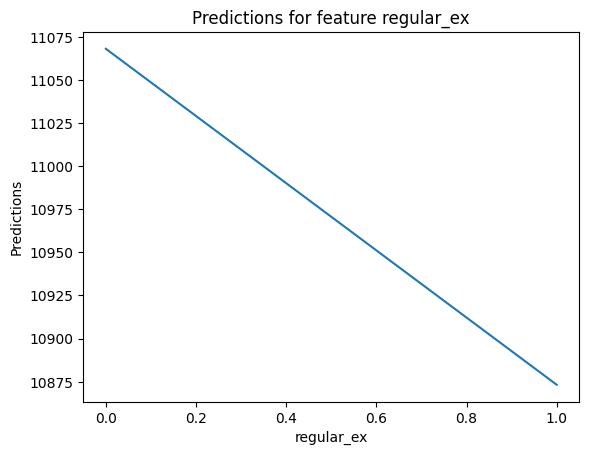

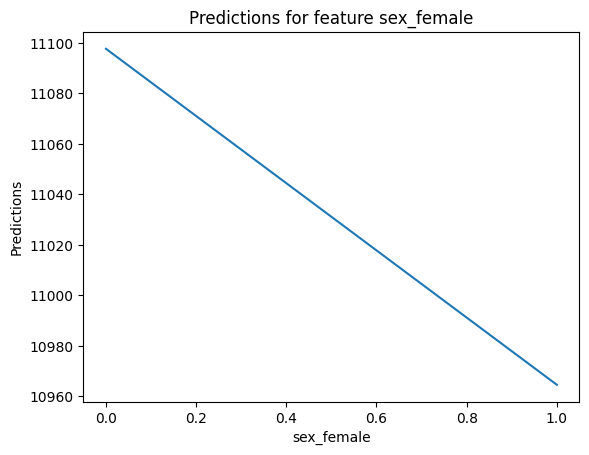

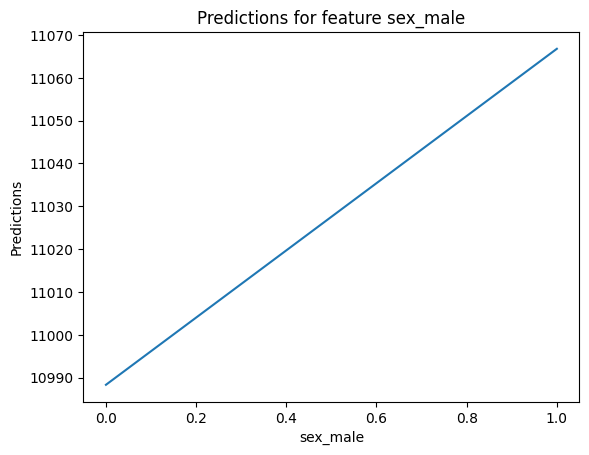

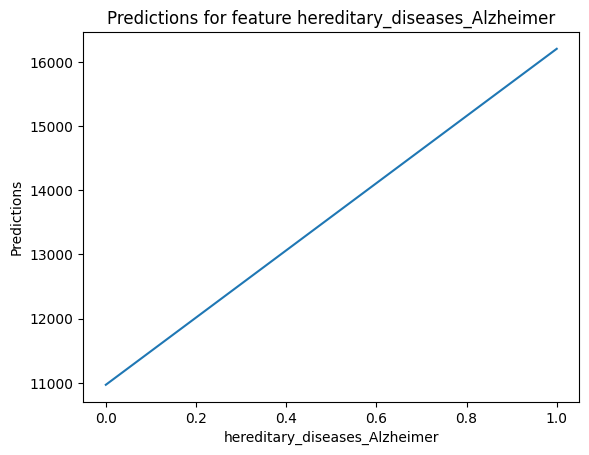

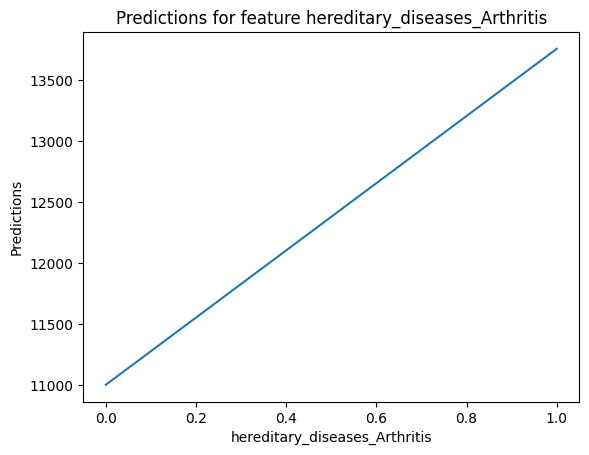

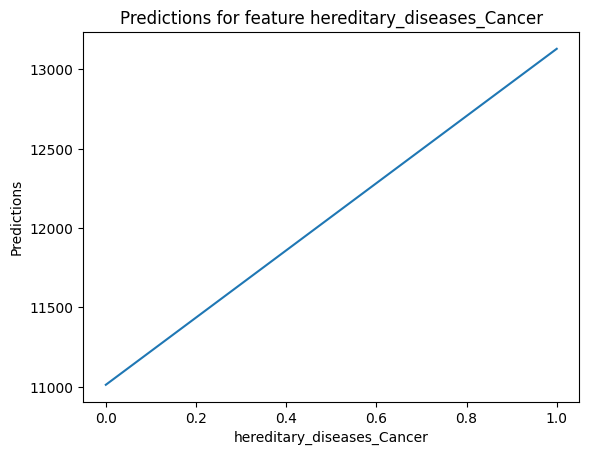

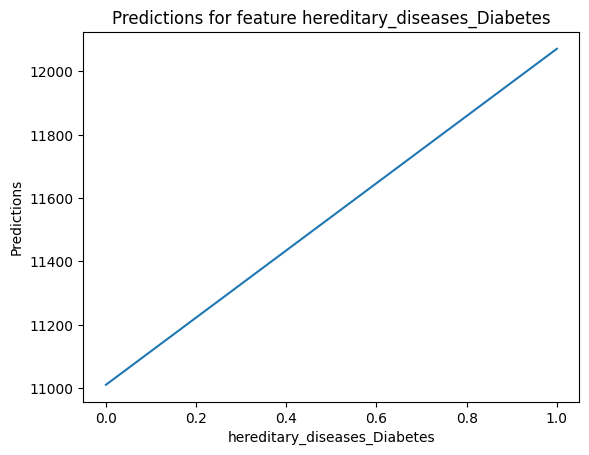

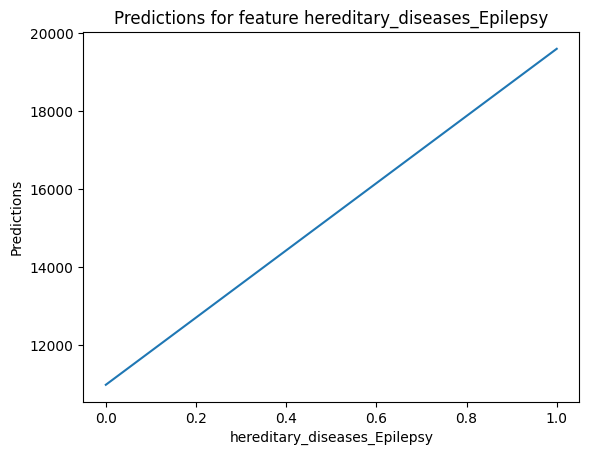

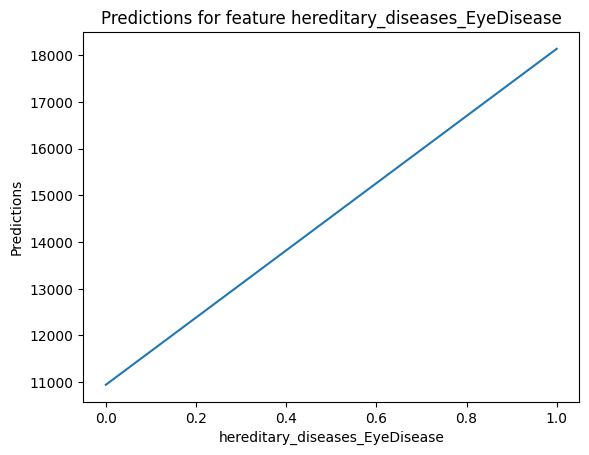

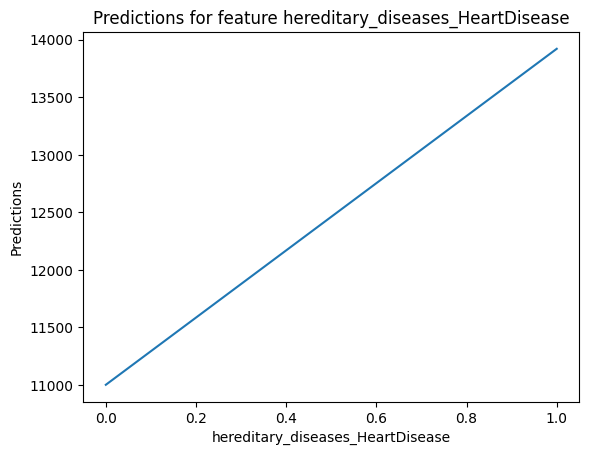

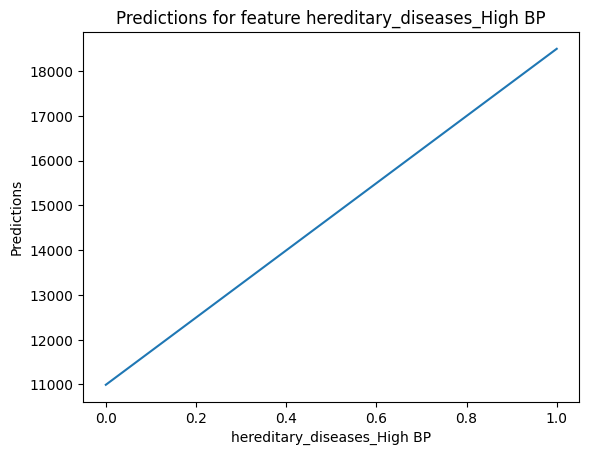

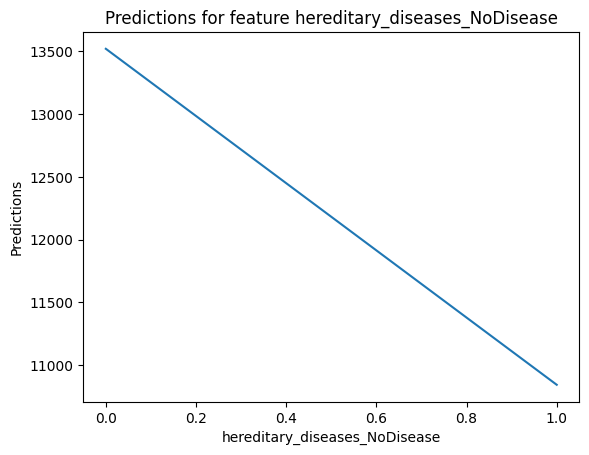

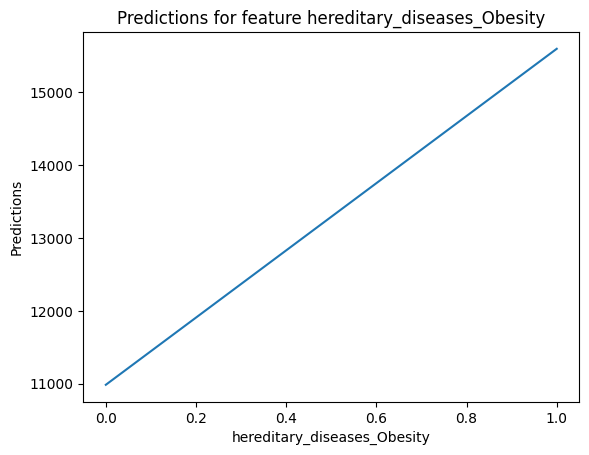

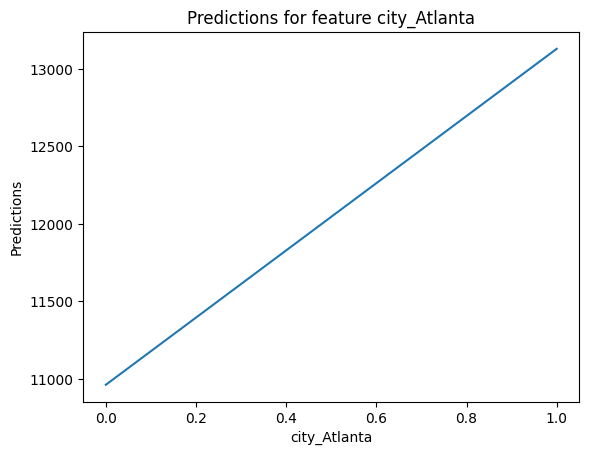

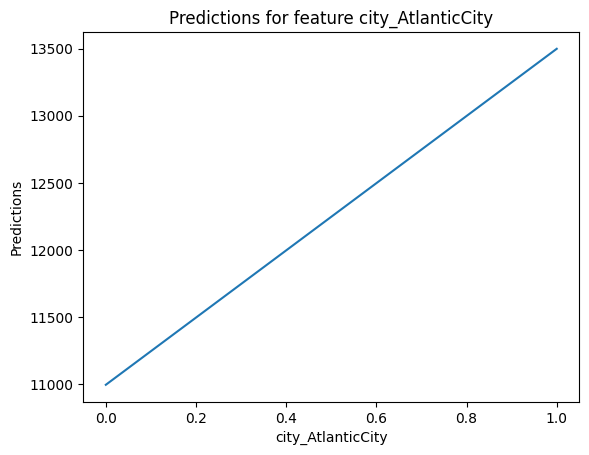

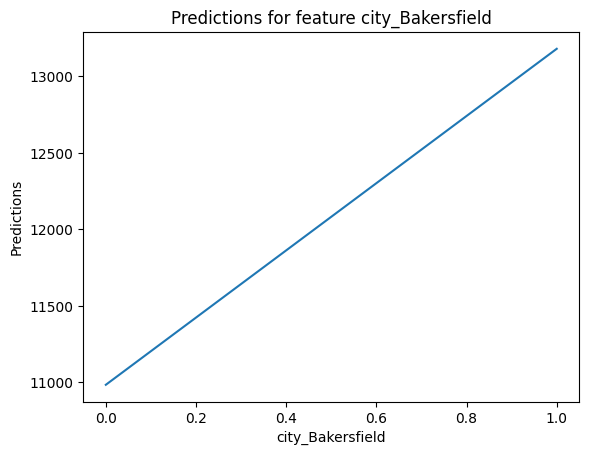

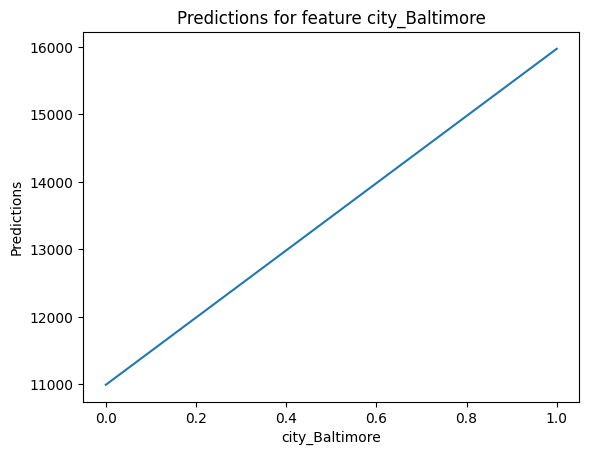

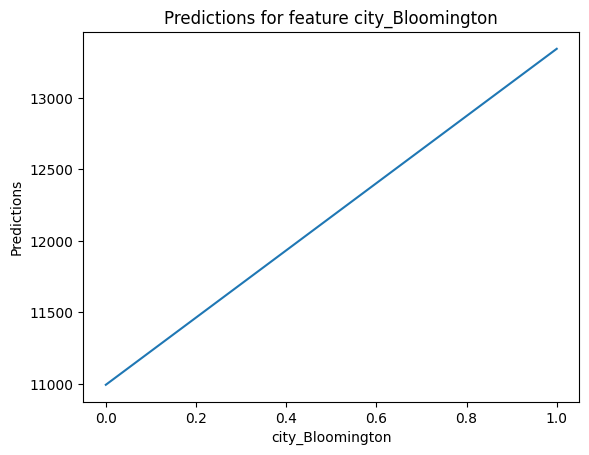

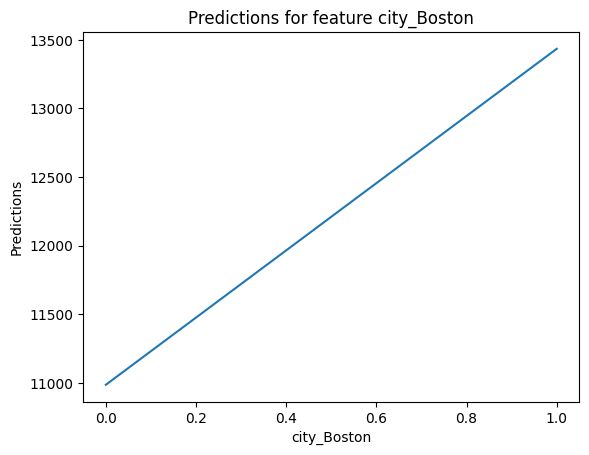

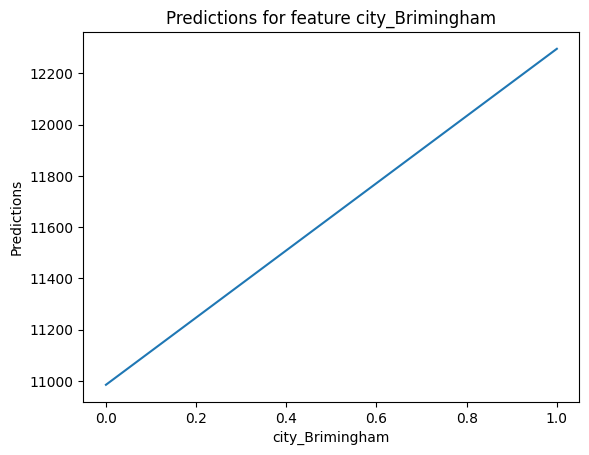

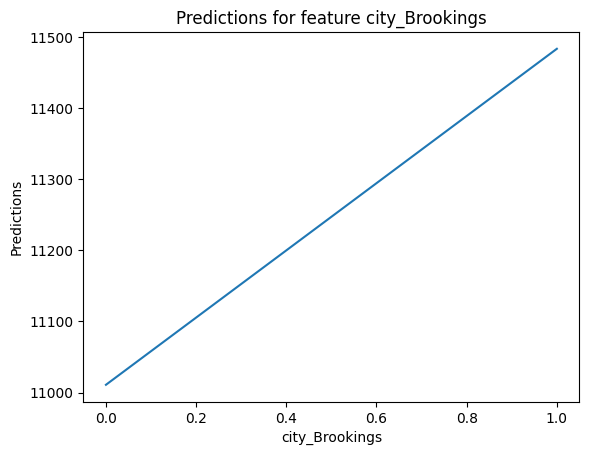

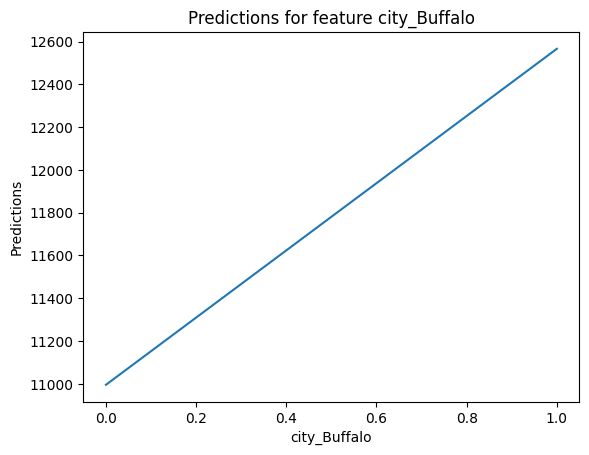

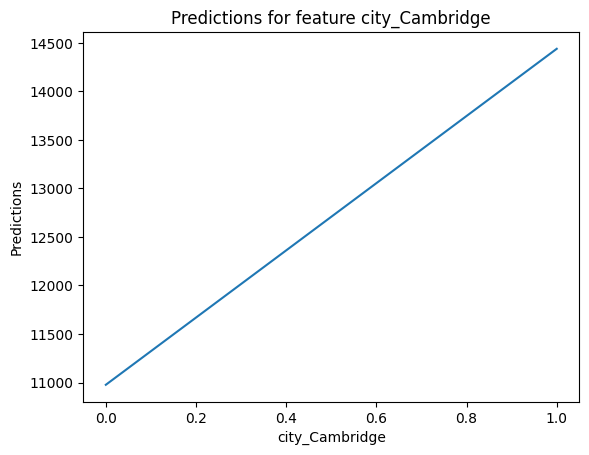

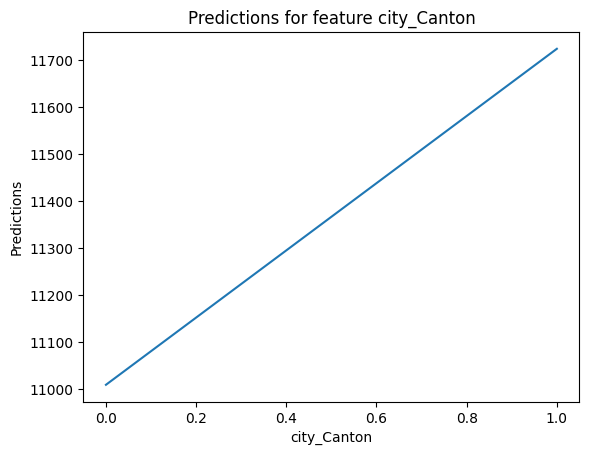

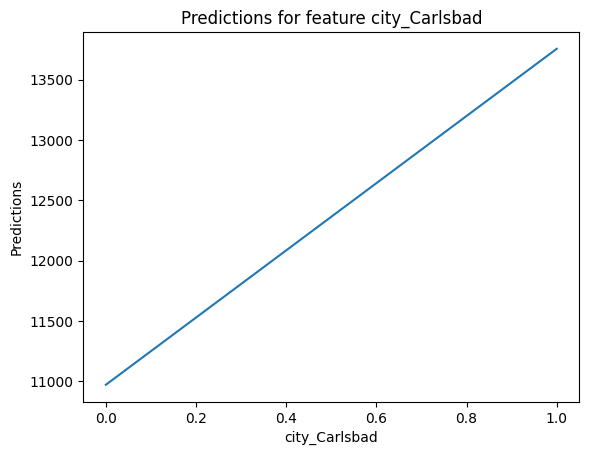

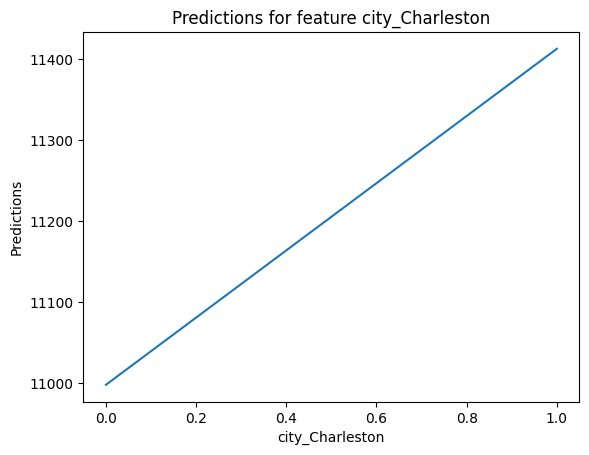

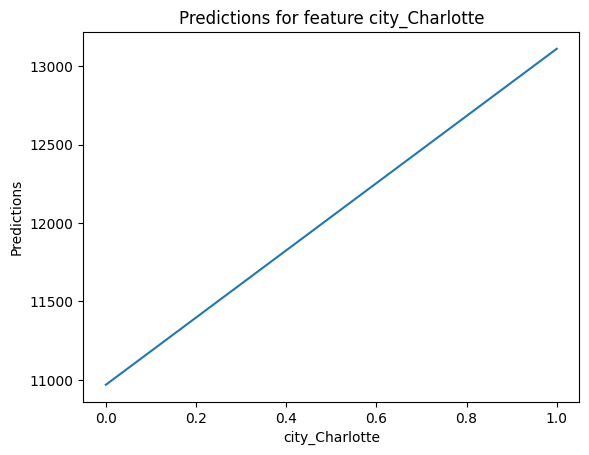

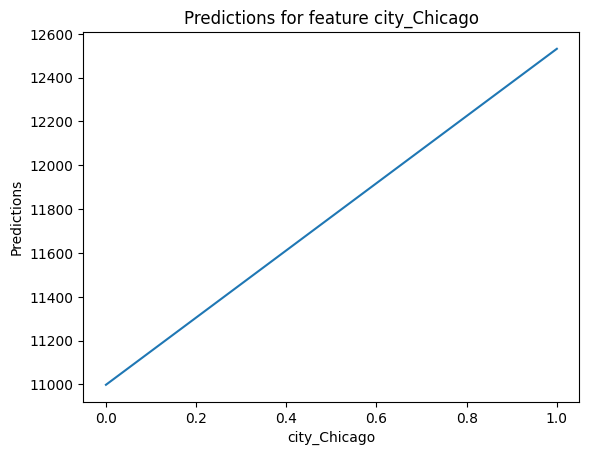

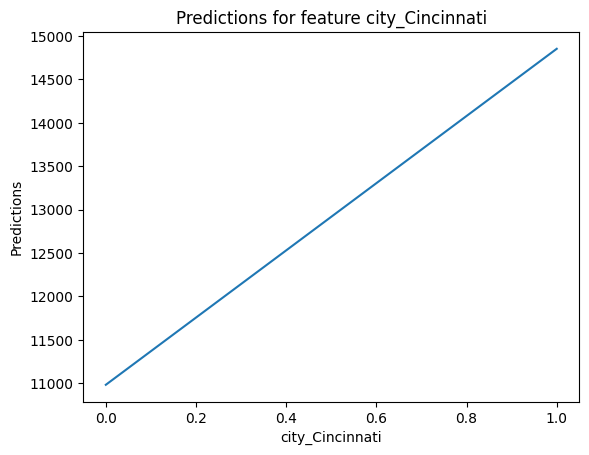

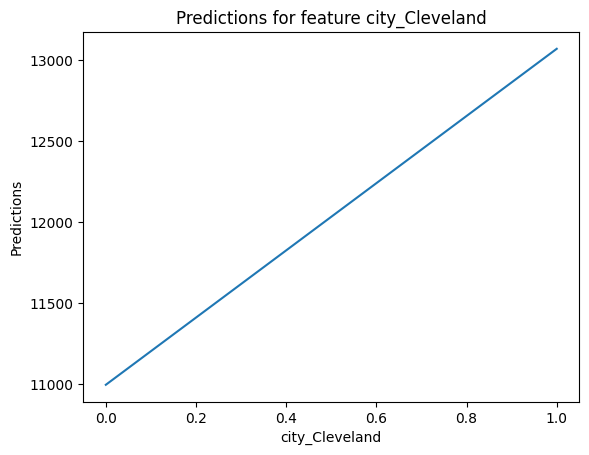

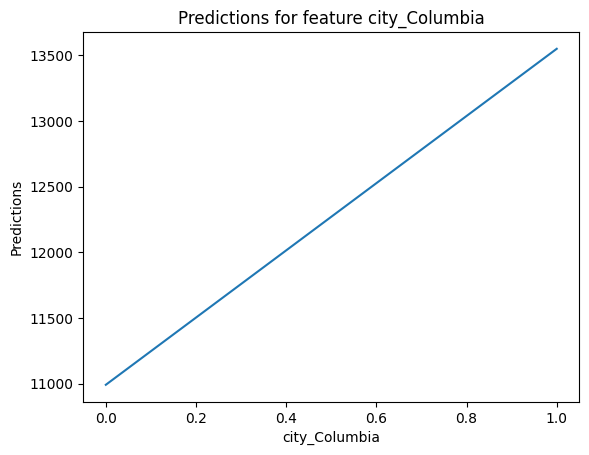

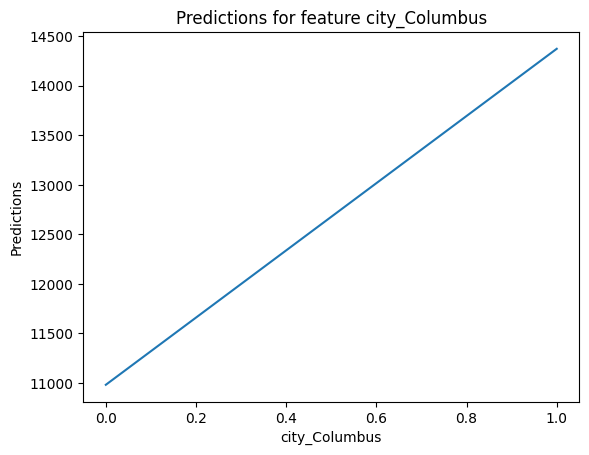

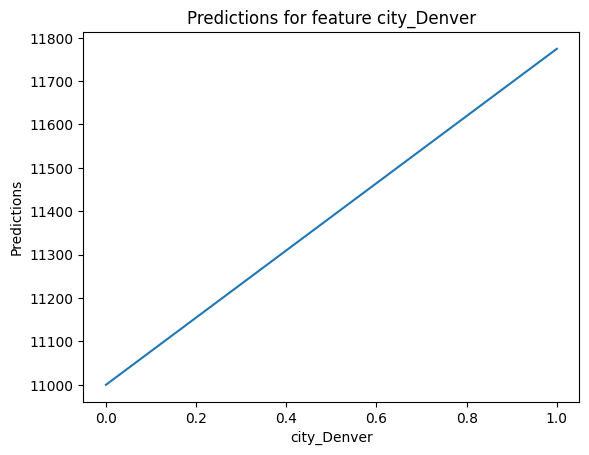

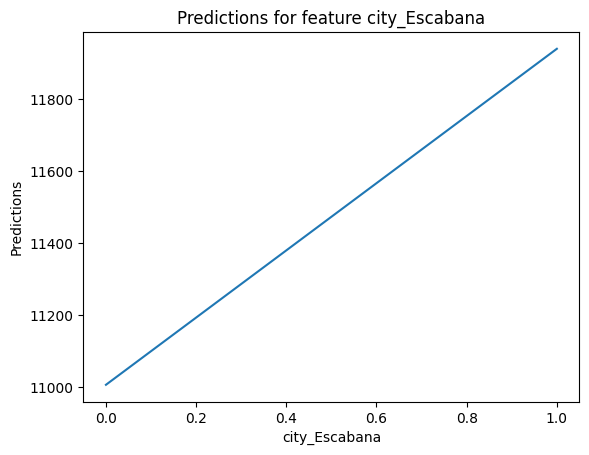

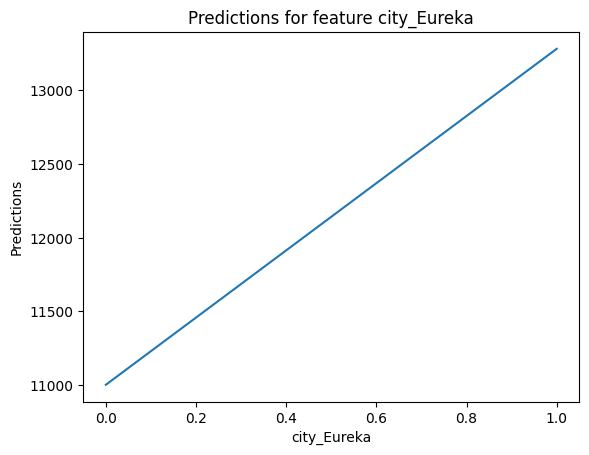

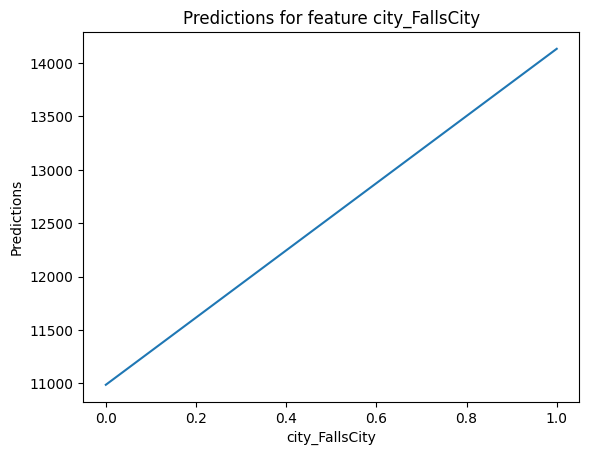

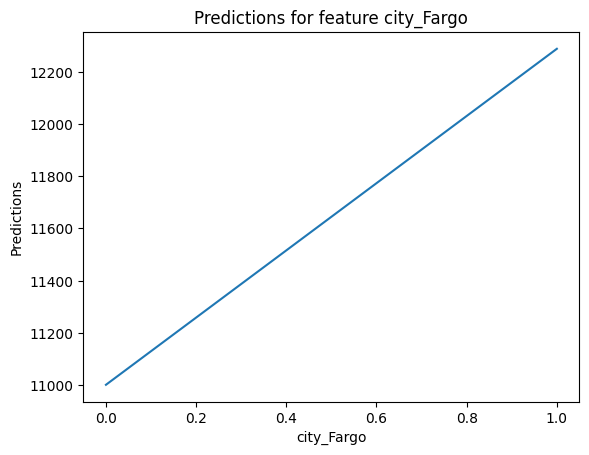

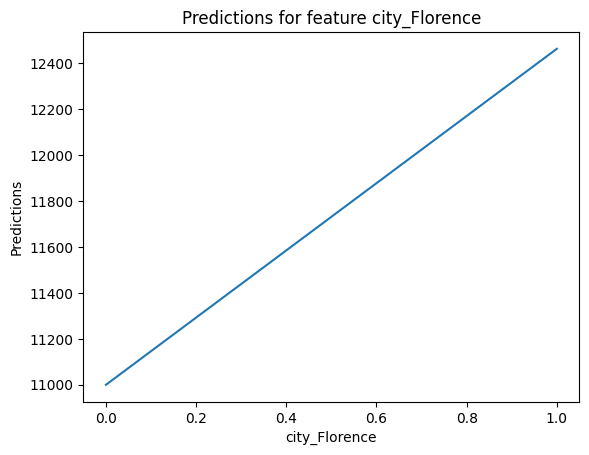

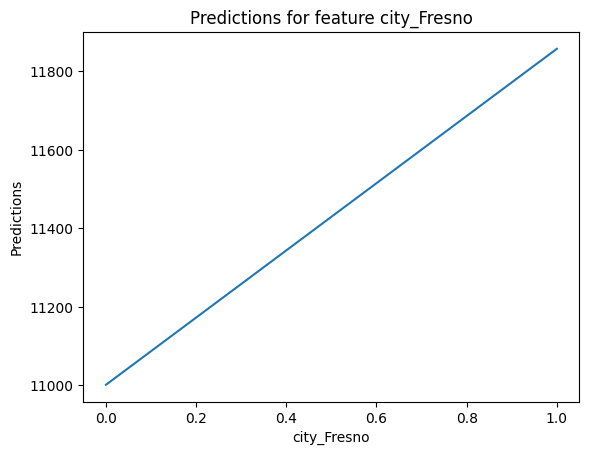

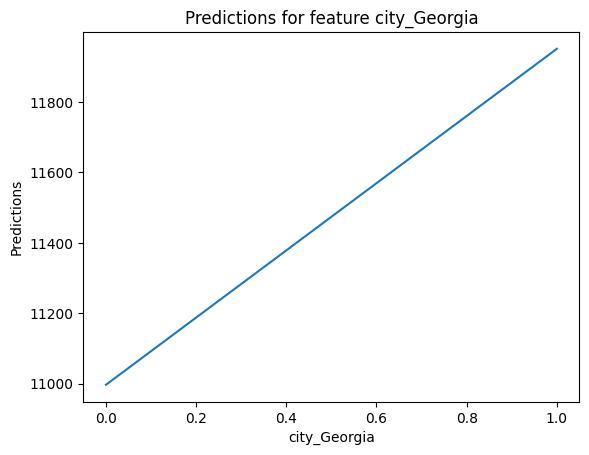

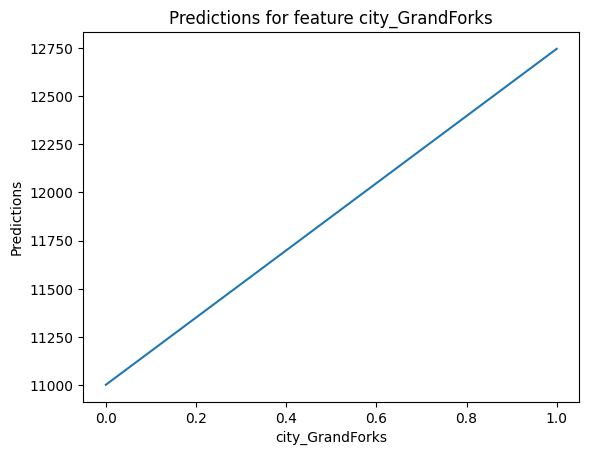

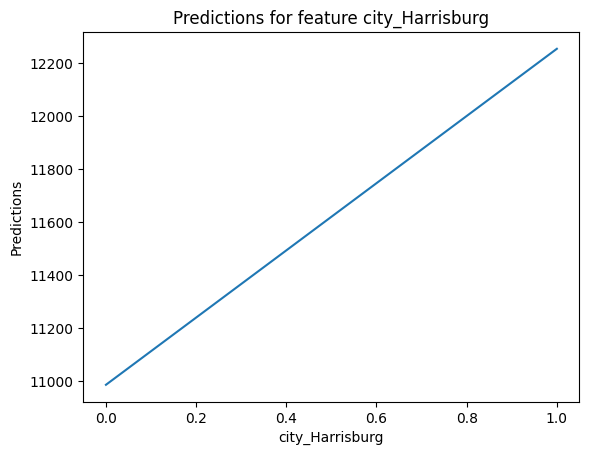

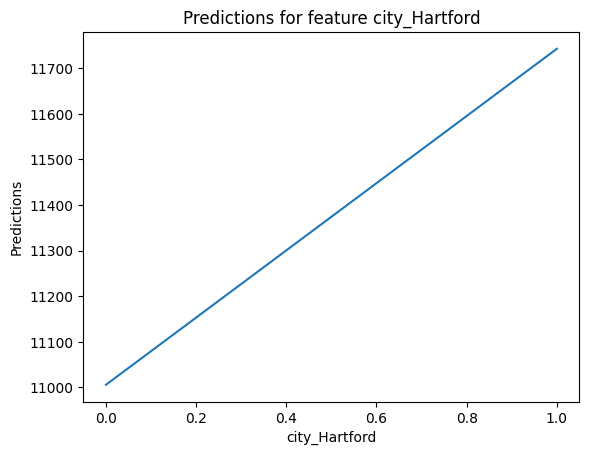

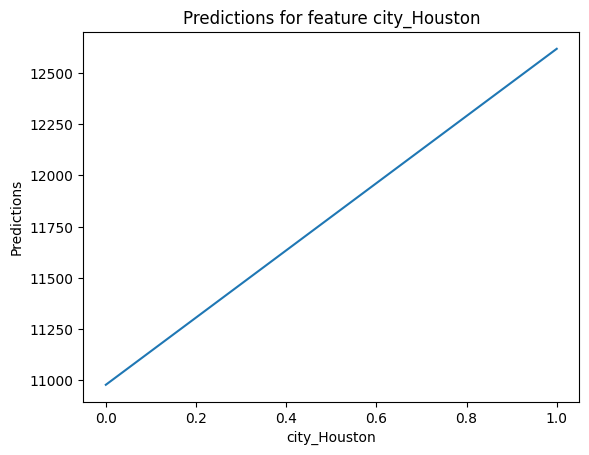

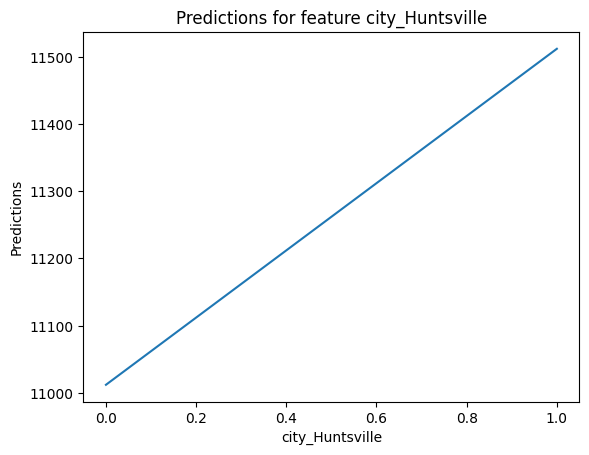

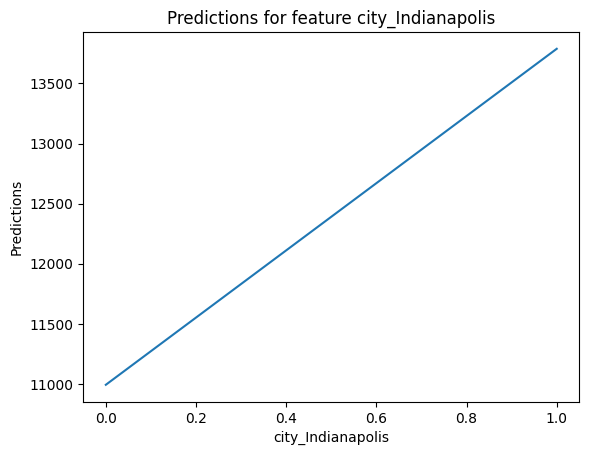

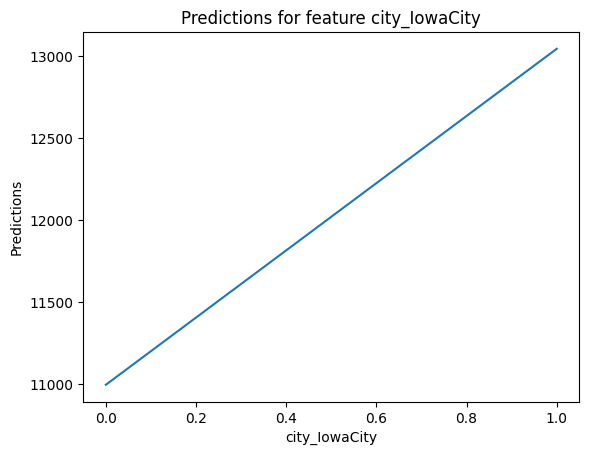

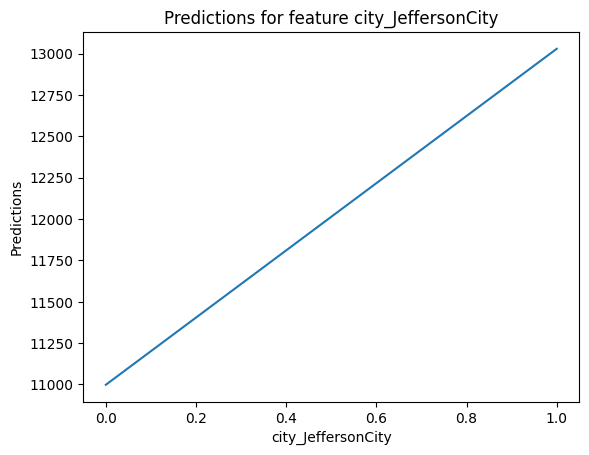

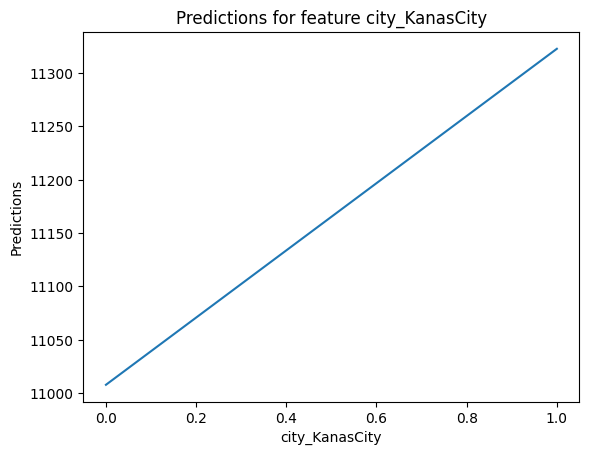

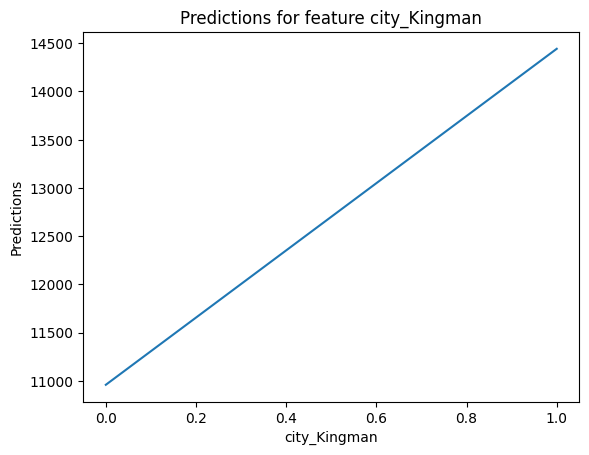

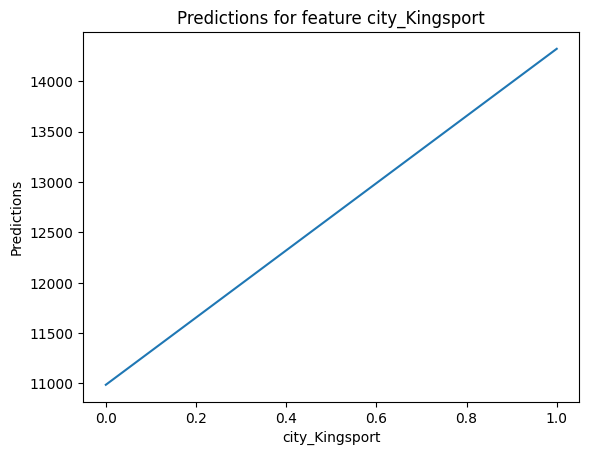

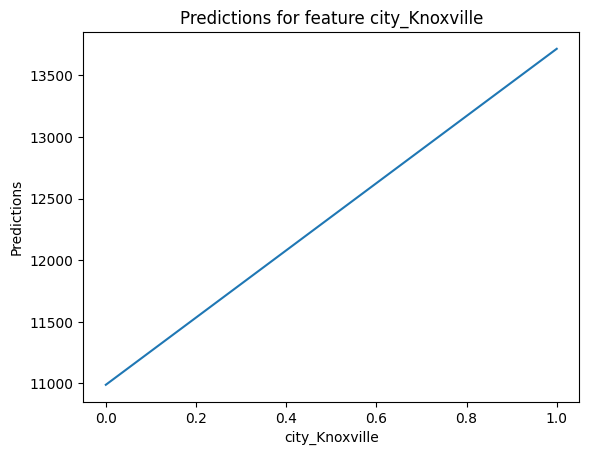

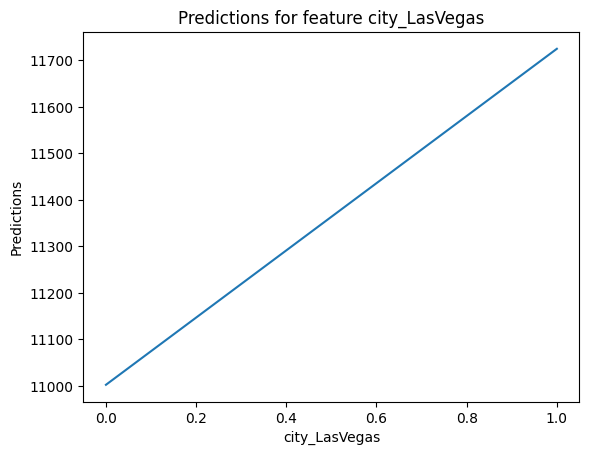

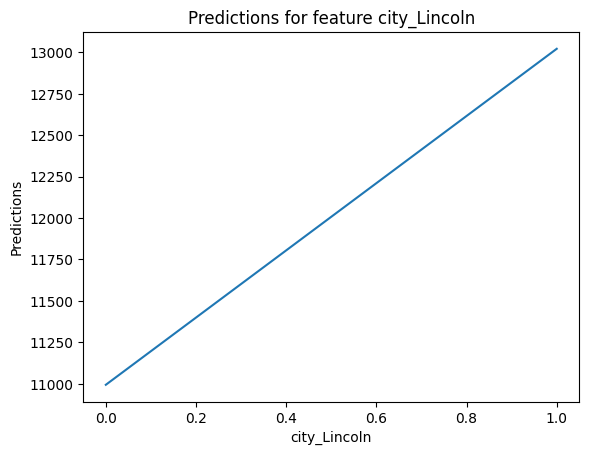

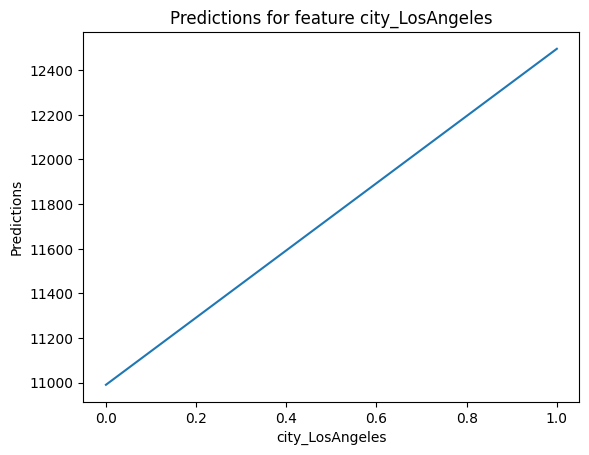

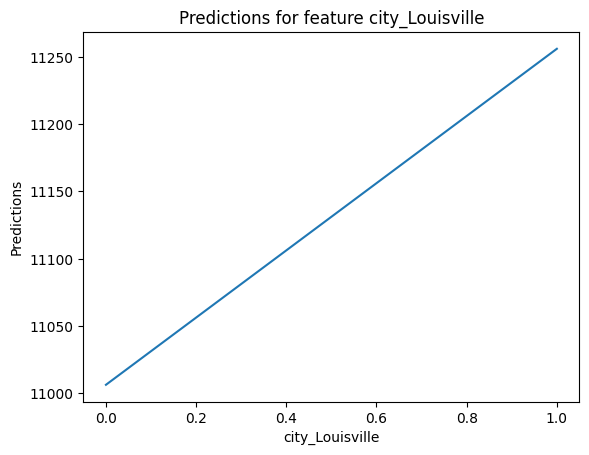

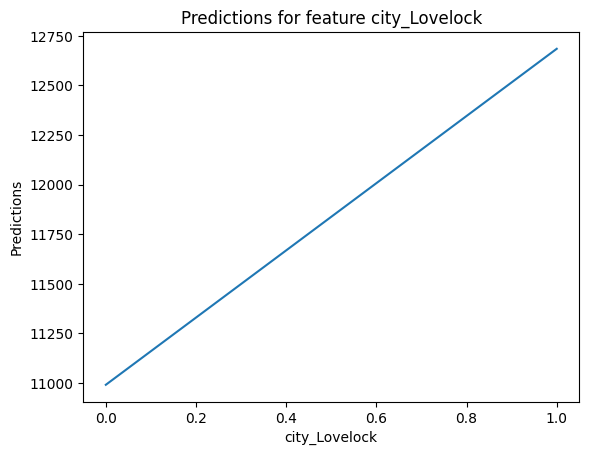

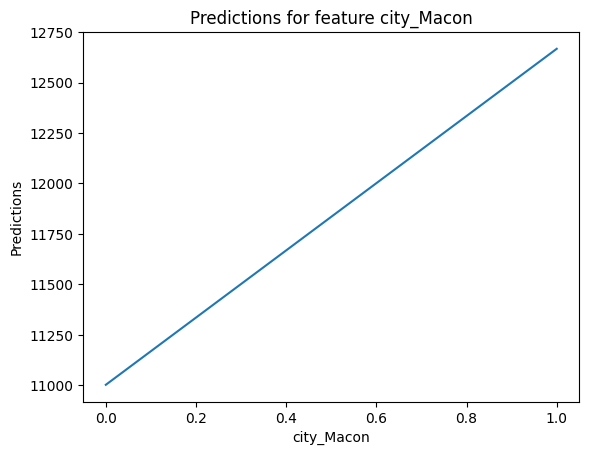

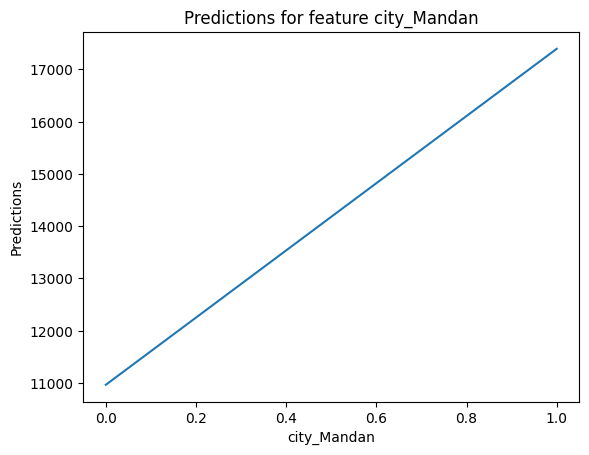

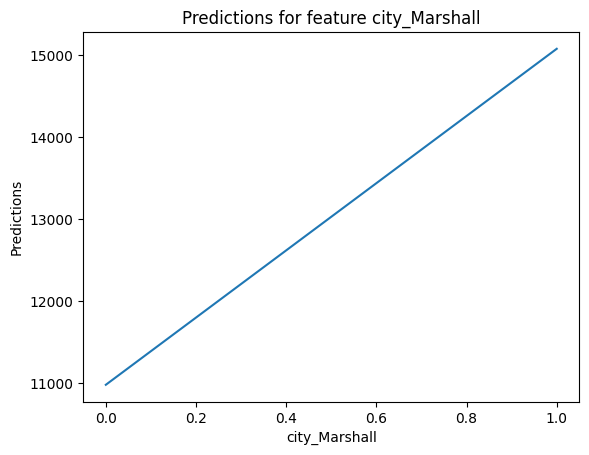

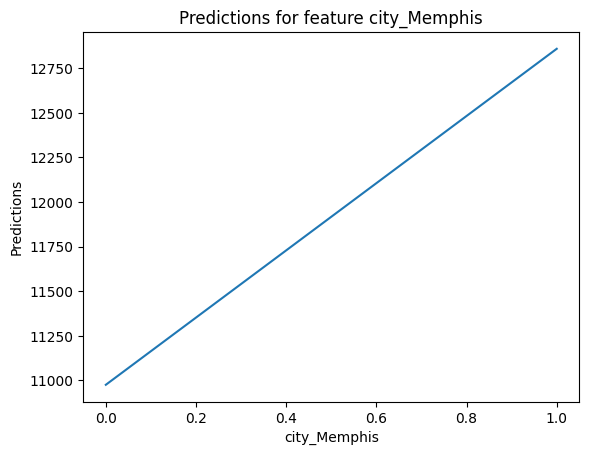

KeyboardInterrupt: 

In [ ]:
#get a feature name list
feature_names = list(X_train_pandas.columns)

#plot the predictions for all features
for feature_name in feature_names:
    plot_predictions(model, feature_name, X_train_pandas, X_train_scaled_pandas)
